# Texas Voter Analysis

**Prediction**: We are trying to predict how a Texas district will vote given its population data.

**Thesis**: Showing how district demographic features determine what share of the district votes Republican.

## Dependent Variable: Proportion of Republican voters in each congressional district
To obtain our dependent variable, we used **requests.get** and **pandas.read_html** on the election result pages of the **2018 Midterm Elections** from the Texas Secretary of State's website. <br />
<br />
We cleaned and exported the raw html into a CSV for each race. We were then able to loop through the CSVs to extract the exact data we needed: **Repulican vote count** and **total votes**.


In [1]:
races_list = list(range(0,38))
def tx_race_csv_creator(num_list):
    for race_num in num_list:
        if race_num > 0 and race_num < 37:
            pull = requests.get('https://enrpages.sos.state.tx.us/public/nov06_331_race'+str(race_num)+'.htm')
            df_raw = pd.read_html(pull.text)[0]
            if len(df_raw.columns) == 7:
                df_raw.columns = column_header_lib
            elif len(df_raw.columns) == 6:
                df_raw.columns = column_header_no_lib
            elif len(df_raw.columns) == 8:
                df_raw.columns = column_header_lib_ind
            else:
                return print("ERROR! Invalid Column Header")
            df_remove_early = df_raw[df_raw["County"]!="Early"]
            df = df_remove_early.drop(df_remove_early.index[0:3])
            df.to_csv('/Users/jim_jack/Documents/mod_2_project/mod_2_project_ds102218/results_csvs/TX_'+str(race_num)+'.csv')
        elif race_num == 0:
            pull = requests.get('https://enrpages.sos.state.tx.us/public/nov06_331_race'+str(race_num)+'.htm')
            df_raw = pd.read_html(pull.text)[0]
            df_raw.columns = column_header
            df_remove_early = df_raw[df_raw["County"]!="Early"]
            df = df_remove_early.drop(df_remove_early.index[0:3])
            df.to_csv('/Users/jim_jack/Documents/mod_2_project/mod_2_project_ds102218/results_csvs/US_Sen.csv')
        else:
            pull = requests.get('https://enrpages.sos.state.tx.us/public/nov06_331_race'+str(race_num)+'.htm')
            df_raw = pd.read_html(pull.text)[0]
            df_raw.columns = column_header
            df_remove_early = df_raw[df_raw["County"]!="Early"]
            df = df_remove_early.drop(df_remove_early.index[0:3])
            df.to_csv('/Users/jim_jack/Documents/mod_2_project/mod_2_project_ds102218/results_csvs/TX_Gov.csv')
        print("Created csv for Race Number: "+str(race_num))
        if race_num == num_list[-1]:
            print("All Results Data Updated")

We took the extracted data and put it into its own Pandas dataframe and calculated the share of Republican votes for the senate, gubernatorial and each congressional election.

In [2]:
def create_summary_df():
    path = '/Users/jim_jack/Documents/mod_2_project/mod_2_project_ds102218/results_csvs'
    allFiles = glob.glob(path + "/*.csv")
    df_summary = []
    for data in allFiles:
        df_dict = {}
        local_df = pd.read_csv(data)
        df_dict['Race'] = file_name_finder(data)
        if "REP" in local_df.columns:
            df_dict['REP'] = local_df.iloc[0]["REP"]
        else:
            df_dict["REP"] = 0
        df_dict['Total Votes'] = local_df.iloc[0]["Total Votes"]
        df_summary.append(df_dict)
    return pd.DataFrame(df_summary)

<img src="files/dep-var-df.png">

## Independent Variables

For our study, we thought about what metrics would lead to a particular district vote Republican.
* Proportion of district that is of the baby-boomer generation and older
    * The baby-boomer generation is defined (on Wikipedia) as people born in the year **1964 and later**. Since the raw data given gives us the number of people in each age group, we took the age group *45 to 54* and multiplied that by 0.2, as a fifth of the people in that group would be considered 'baby boomers' in the year 2017
    * We also took this proportion out of people aged **18 and up**, because we wanted to only look at people eligible to vote
* Proportion of the district that is White
* Proportion of the district that is male
* Proportion of the district that was born in Texas
    * We took this proportion out of the number of people in the district that were born in the United States
* Mean income
* Education attainment
    * We looked at the proportion of the district that achieved an education **past high school** -- including Associate's degrees, Bachelor's degrees, and higher
* Unemployment rate
* Buc-ee's: our categorical variable

We have a function for each new column!
(with the exception of mean income, that we pull directly from the cleaned table)

In [3]:
def babyboomers(row):
    teens = [int(row['15 to 19 years'])*0.4]
    youngbbbs = [int(row['45 to 54 years'])*0.2]
    agegroups = ['20 to 24 years','25 to 34 years','35 to 44 years','45 to 54 years','55 to 59 years',
                 '60 to 64 years','65 to 74 years','75 to 84 years','85 years and over']
    popn = sum(teens + list(map(lambda a: int(row[a]), agegroups)))
    age_groups = ['55 to 59 years', '60 to 64 years','65 to 74 years','75 to 84 years','85 years and over']
    return sum(youngbbbs + list(map(lambda a: int(row[a]), age_groups)))/popn

def prop_white(row):
    return int(row['White'])/int(row['Total population'].head(1))

def prop_male(row):
    return int(row['Male'])/int(row['Total population'].head(1))

def texas_born(row):
    return int(row['State of residence'])/int(row['Born in United States'])

def higheredu(row):
    return (int(row["Associate's degree"])+int(row["Bachelor's degree"])+ \
            int(row["Graduate or professional degree"]))/int(row["Population 25 years and over"])

def unemployment(row):
    return int(row['Unemployed'])/int(row['Civilian labor force'].head(1))

In [4]:
import pandas as pd
import numpy as np
texas_raw = pd.read_csv('Texas_District_all.csv')
texas_raw.head() 
labelled = texas_raw.set_index('Title') # setting the index to the metric measured
table_headers = list(map(lambda x: 'District 0'+str(x)+' Estimate', range(1, 10))) + \
                list(map(lambda x: 'District '+str(x)+' Estimate', range(10, 37))) # new headers
cleaned = labelled.loc[:, table_headers].transpose().dropna(axis=1) # dropping the NaN columns
df = pd.DataFrame(index = cleaned.index) 


In [5]:
# scraping for districts with Buc-ee's

from bs4 import BeautifulSoup
import requests
import re
url = 'https://www.buc-ees.com/locations.php'
html = requests.get(url)
soup = BeautifulSoup(html.content, 'html.parser')
locationsoup = soup.findAll({'div': 'container'})[13:40]
loc = []
for location in locationsoup:
    loc += location.findAll('p')[-1].contents
addresses = list(filter(lambda l: 'TX' in l, loc))

In [6]:
districts = [22, 14, 10, 36, 14, 10, 26, 10, 27, 26, 14, 10, 27, 10, 14, 22, 27, 8, 35, 22, 27, 22, 31, 5, 14, 10, 27]
list(sorted(set(districts)))

[5, 8, 10, 14, 22, 26, 27, 31, 35, 36]

In [7]:
# adding columns into our new dataframe!

df['older_proportion'] = cleaned.apply(lambda row: babyboomers(row),axis=1)
df['proportion_white'] = cleaned.apply(lambda row: prop_white(row),axis=1)
df['proportion_male'] = cleaned.apply(lambda row: prop_male(row),axis=1)
df['born_in_TX'] = cleaned.apply(lambda row: texas_born(row),axis=1)
df['mean_income'] = pd.to_numeric(cleaned['Mean household income (dollars)'])
df['higher_education'] = cleaned.apply(lambda row: higheredu(row),axis=1)
df['unemployment_rate'] = cleaned.apply(lambda row: unemployment(row),axis=1)
beaver_locations = [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
df["bucees"] = np.array(beaver_locations)
df.head()

,older_proportion,proportion_white,proportion_male,born_in_TX,mean_income,higher_education,unemployment_rate,bucees
District 01 Estimate,0.421819,0.770341,0.488964,0.773983,66809,0.297772,0.060640,0
District 02 Estimate,0.352724,0.676836,0.500970,0.651026,108618,0.490439,0.042236,0
District 03 Estimate,0.338312,0.685146,0.490954,0.555650,122057,0.612976,0.036385,0
District 04 Estimate,0.426503,0.812625,0.491080,0.725613,74581,0.315266,0.049219,0
District 05 Estimate,0.373478,0.773341,0.502425,0.769360,69802,0.265619,0.047108,1


### Correlation Analysis
Based on the correlation table below, we can see that the three variables **mean income**, **higher education** and **born in Texas** are very highly correlated with each other. Therefore, we decide to drop the former two.



In [8]:
df.corr()

,older_proportion,proportion_white,proportion_male,born_in_TX,mean_income,higher_education,unemployment_rate,bucees
older_proportion,1.000000,0.489234,-0.052985,-0.074147,0.107922,0.020705,-0.267486,0.113633
proportion_white,0.489234,1.000000,0.305883,0.183913,-0.134012,-0.177832,-0.167455,0.064180
proportion_male,-0.052985,0.305883,1.000000,0.239094,-0.151797,-0.301555,0.054639,0.175571
born_in_TX,-0.074147,0.183913,0.239094,1.000000,-0.880158,-0.896623,0.688006,-0.185320
mean_income,0.107922,-0.134012,-0.151797,-0.880158,1.000000,0.933985,-0.588324,0.223564
higher_education,0.020705,-0.177832,-0.301555,-0.896623,0.933985,1.000000,-0.649680,0.121578
unemployment_rate,-0.267486,-0.167455,0.054639,0.688006,-0.588324,-0.649680,1.000000,-0.020370
bucees,0.113633,0.064180,0.175571,-0.185320,0.223564,0.121578,-0.020370,1.000000


In [9]:
final_independent = df.drop(['mean_income', 'higher_education'], axis=1)
final_independent.head()

,older_proportion,proportion_white,proportion_male,born_in_TX,unemployment_rate,bucees
District 01 Estimate,0.421819,0.770341,0.488964,0.773983,0.060640,0
District 02 Estimate,0.352724,0.676836,0.500970,0.651026,0.042236,0
District 03 Estimate,0.338312,0.685146,0.490954,0.555650,0.036385,0
District 04 Estimate,0.426503,0.812625,0.491080,0.725613,0.049219,0
District 05 Estimate,0.373478,0.773341,0.502425,0.769360,0.047108,1


## Putting all our data together!

We output all our variables into a CSV file for easy access. In preperation for our regression, we also output a scatter matrix and heatmap to visualize how the independent variables interact with each other and the dependent variable.

In [10]:
# final_independent.to_csv('full_data.csv')

In [71]:
data = pd.read_csv('full_data.csv')
data.head()

,Unnamed: 0,older_proportion,proportion_white,proportion_male,born_in_TX,unemployment_rate,bucees
0,District 01 Estimate,0.421819,0.770341,0.488964,0.773983,0.060640,0
1,District 02 Estimate,0.352724,0.676836,0.500970,0.651026,0.042236,0
2,District 03 Estimate,0.338312,0.685146,0.490954,0.555650,0.036385,0
3,District 04 Estimate,0.426503,0.812625,0.491080,0.725613,0.049219,0
4,District 05 Estimate,0.373478,0.773341,0.502425,0.769360,0.047108,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11854cf98>,
      dtype=object)

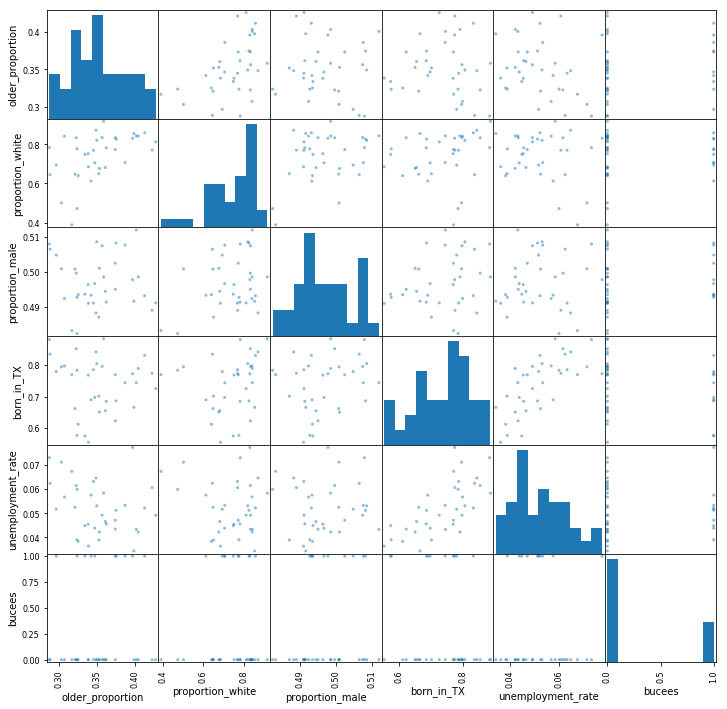

In [13]:
import matplotlib.pyplot as plt
pd.plotting.scatter_matrix(data, figsize=[12, 12])

Text(0.5,1,'Heatmap of Correlation between Features')

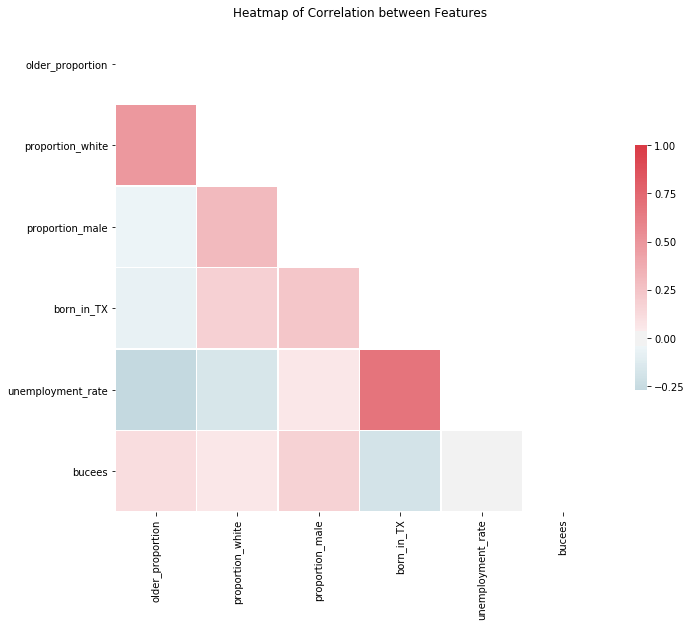

In [14]:
import seaborn as sns
corr = data.corr() 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation between Features')

In [15]:
data.corr()

,older_proportion,proportion_white,proportion_male,born_in_TX,unemployment_rate,bucees
older_proportion,1.000000,0.489234,-0.052985,-0.074147,-0.267486,0.113633
proportion_white,0.489234,1.000000,0.305883,0.183913,-0.167455,0.064180
proportion_male,-0.052985,0.305883,1.000000,0.239094,0.054639,0.175571
born_in_TX,-0.074147,0.183913,0.239094,1.000000,0.688006,-0.185320
unemployment_rate,-0.267486,-0.167455,0.054639,0.688006,1.000000,-0.020370
bucees,0.113633,0.064180,0.175571,-0.185320,-0.020370,1.000000


## Regression Time!!!

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import datasets, linear_model
from sklearn import metrics

We first add our dependent variable to the table of independent variables.

In [72]:
df_election_data = pd.read_csv('election_data.csv')
df_district_results = df_election_data.iloc[0:-2]
df_district_results.head()

,Race,REP,Total Votes,prop_r_vote
0,TX_01,167734,231969,0.723088
1,TX_02,139012,262924,0.528716
2,TX_03,168775,311070,0.542563
3,TX_04,188003,248373,0.756938
4,TX_05,130404,209147,0.623504


In [73]:
data['prop_r_vote'] = df_district_results['prop_r_vote']

In [76]:
full_data = data.set_index('Unnamed: 0')

In [77]:
full_data.head()

,older_proportion,proportion_white,proportion_male,born_in_TX,unemployment_rate,bucees,prop_r_vote
Unnamed: 0,,,,,,,
District 01 Estimate,0.421819,0.770341,0.488964,0.773983,0.060640,0,0.723088
District 02 Estimate,0.352724,0.676836,0.500970,0.651026,0.042236,0,0.528716
District 03 Estimate,0.338312,0.685146,0.490954,0.555650,0.036385,0,0.542563
District 04 Estimate,0.426503,0.812625,0.491080,0.725613,0.049219,0,0.756938
District 05 Estimate,0.373478,0.773341,0.502425,0.769360,0.047108,1,0.623504


# Attempt 1
Initial regression with original features.

In [87]:
outcome_1 = 'prop_r_vote'
predictors = full_data.drop([outcome_1], axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome_1 + "~" + pred_sum

In [88]:
model = ols(formula= formula, data=full_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            prop_r_vote   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     18.54
Date:                Thu, 06 Dec 2018   Prob (F-statistic):           9.89e-09
Time:                        14:17:56   Log-Likelihood:                 30.319
No. Observations:                  36   AIC:                            -46.64
Df Residuals:                      29   BIC:                            -35.55
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.8105      1.462     -4.658      0.000      -9.801      -3.820
older_proportion      4.1519      0.644      6.448      0.000       2.835       5.469
proportion_white      0.0565      0.218      0.259      0.798      -0.390       0.503
proportion_male      13.1086      2.967      4.418      0.000       7.040      19.177
born_in_TX           -0.8282      0.369     -2.243      0.033      -1.583      -0.073
unemployment_rate    -2.4426      2.860     -0.854      0.400      -8.291       3.406
bucees                0.0215      0.047      0.458      0.650      -0.074       0.117
==============================================================================
Omnibus:                        1.127   Durbin-Watson:                   2.374
Prob(Omnibus):                  0.569   Jarque-Bera (JB):                1.017
Skew:                          -0.219   Prob(JB):                        0.601
Kurtosis:                       2.302   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysis of Attempt 1
* Initial model outcome - **prop_white** and **unemployment_rate** both have insignificant p-values. We decide to remove these variables and retest.
* Based on p-values, we know that **older_proportion**, **proportion_male** and **born_in_TX** are relatively significant variables
* Our adjusted R<sup>2</sup> is **0.750**!!!

# Attempt 2
* Remove the insignificant variables and retest R<sup>2


In [89]:
outcome_2 = 'prop_r_vote'
predictors_2 = full_data.drop([outcome_2,"unemployment_rate",'proportion_white'], axis=1)
pred_sum_2 = "+".join(predictors_2.columns)
formula_2 = outcome_2 + "~" + pred_sum_2
model_2 = ols(formula= formula_2, data=full_data).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            prop_r_vote   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     28.48
Date:                Thu, 06 Dec 2018   Prob (F-statistic):           5.48e-10
Time:                        14:25:26   Log-Likelihood:                 29.711
No. Observations:                  36   AIC:                            -49.42
Df Residuals:                      31   BIC:                            -41.50
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.2504      1.338     -5.419      0.000      -9.979      -4.522
older_proportion     4.4164      0.525      8.409      0.000       3.345       5.488
proportion_male     13.9595      2.723      5.127      0.000       8.406      19.513
born_in_TX          -1.0431      0.237     -4.409      0.000      -1.526      -0.561
bucees               0.0111      0.045      0.248      0.806      -0.080       0.102
==============================================================================
Omnibus:                        0.832   Durbin-Watson:                   2.446
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.771
Skew:                          -0.044   Prob(JB):                        0.680
Kurtosis:                       2.289   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Our adjusted R<sup>2</sup> is now **0.758**, which justifies the removal of the two variables
* *The Beaver is significant in our hearts*

<img src="files/download.jpg">

### Train Test Split on Attempt 2

In [92]:
#Need to relabel these terms before rerunning notebook; Original features only; picking highest p-values (and bucees)
X_train, X_test, y_train, y_test = train_test_split(predictors_2, full_data.prop_r_vote, test_size = 0.2)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.012113388445034337
Test Mean Squarred Error: 0.009091545549922224


# Attempt 3
Adding polynomial features and filter model testing -- an attempt to reduce MSE further.

In [97]:
features = full_data.iloc[:,:-1]
target = full_data.prop_r_vote
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(features, target, test_size = 0.2)
scaler = preprocessing.StandardScaler()
scaler.fit(features.iloc[:,:-1])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [98]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_plus_train = pd.DataFrame(poly.fit_transform(X_train_features), columns=poly.get_feature_names(X_train_features.columns))
features_plus_train.head()

,older_proportion,proportion_white,proportion_male,born_in_TX,unemployment_rate,bucees,older_proportion^2,older_proportion proportion_white,older_proportion proportion_male,older_proportion born_in_TX,...,proportion_male^2,proportion_male born_in_TX,proportion_male unemployment_rate,proportion_male bucees,born_in_TX^2,born_in_TX unemployment_rate,born_in_TX bucees,unemployment_rate^2,unemployment_rate bucees,bucees^2
0,0.316579,0.389004,0.483160,0.769971,0.067354,0.0,0.100222,0.123151,0.152959,0.243757,...,0.233444,0.372019,0.032543,0.0,0.592855,0.051861,0.0,0.004537,0.0,0.0
1,0.360520,0.681317,0.494386,0.655495,0.046573,0.0,0.129975,0.245629,0.178236,0.236319,...,0.244418,0.324068,0.023025,0.0,0.429674,0.030529,0.0,0.002169,0.0,0.0
2,0.287191,0.783354,0.507916,0.881093,0.073009,0.0,0.082478,0.224972,0.145869,0.253042,...,0.257978,0.447521,0.037083,0.0,0.776325,0.064328,0.0,0.005330,0.0,0.0
3,0.302898,0.501001,0.500825,0.794404,0.071163,0.0,0.091747,0.151752,0.151699,0.240624,...,0.250825,0.397857,0.035640,0.0,0.631078,0.056532,0.0,0.005064,0.0,0.0
4,0.361713,0.782285,0.491302,0.685364,0.045634,0.0,0.130837,0.282963,0.177710,0.247905,...,0.241378,0.336720,0.022420,0.0,0.469723,0.031276,0.0,0.002082,0.0,0.0


In [99]:
features_plus_test = pd.DataFrame(poly.fit_transform(X_test_features), columns=poly.get_feature_names(X_test_features.columns))
features_plus_test.head()

,older_proportion,proportion_white,proportion_male,born_in_TX,unemployment_rate,bucees,older_proportion^2,older_proportion proportion_white,older_proportion proportion_male,older_proportion born_in_TX,...,proportion_male^2,proportion_male born_in_TX,proportion_male unemployment_rate,proportion_male bucees,born_in_TX^2,born_in_TX unemployment_rate,born_in_TX bucees,unemployment_rate^2,unemployment_rate bucees,bucees^2
0,0.344868,0.769642,0.491038,0.785423,0.063169,0.0,0.118934,0.265425,0.169343,0.270867,...,0.241119,0.385673,0.031019,0.00000,0.616889,0.049615,0.000000,0.003990,0.000000,0.0
1,0.349247,0.820505,0.508546,0.804793,0.053089,0.0,0.121974,0.286559,0.177608,0.281072,...,0.258619,0.409274,0.026998,0.00000,0.647692,0.042725,0.000000,0.002818,0.000000,0.0
2,0.346573,0.705403,0.496610,0.697591,0.043842,1.0,0.120113,0.244474,0.172112,0.241766,...,0.246622,0.346431,0.021772,0.49661,0.486633,0.030584,0.697591,0.001922,0.043842,1.0
3,0.323507,0.471969,0.482330,0.783724,0.059916,0.0,0.104657,0.152685,0.156037,0.253540,...,0.232642,0.378014,0.028899,0.00000,0.614224,0.046957,0.000000,0.003590,0.000000,0.0
4,0.401084,0.843155,0.511930,0.744432,0.043290,0.0,0.160868,0.338176,0.205327,0.298580,...,0.262073,0.381097,0.022162,0.00000,0.554178,0.032227,0.000000,0.001874,0.000000,0.0


In [100]:
def variance_threshold_selector(data, threshold=0.01):
    #changed variance to .25
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [101]:
features_selected_train = variance_threshold_selector(features_plus_train)
features_selected_train.head()

,proportion_white,bucees,older_proportion bucees,proportion_white^2,proportion_white born_in_TX,proportion_white bucees,proportion_male bucees,born_in_TX^2,born_in_TX bucees,bucees^2
0,0.389004,0.0,0.0,0.151324,0.299521,0.0,0.0,0.592855,0.0,0.0
1,0.681317,0.0,0.0,0.464193,0.446600,0.0,0.0,0.429674,0.0,0.0
2,0.783354,0.0,0.0,0.613644,0.690208,0.0,0.0,0.776325,0.0,0.0
3,0.501001,0.0,0.0,0.251002,0.397997,0.0,0.0,0.631078,0.0,0.0
4,0.782285,0.0,0.0,0.611970,0.536150,0.0,0.0,0.469723,0.0,0.0


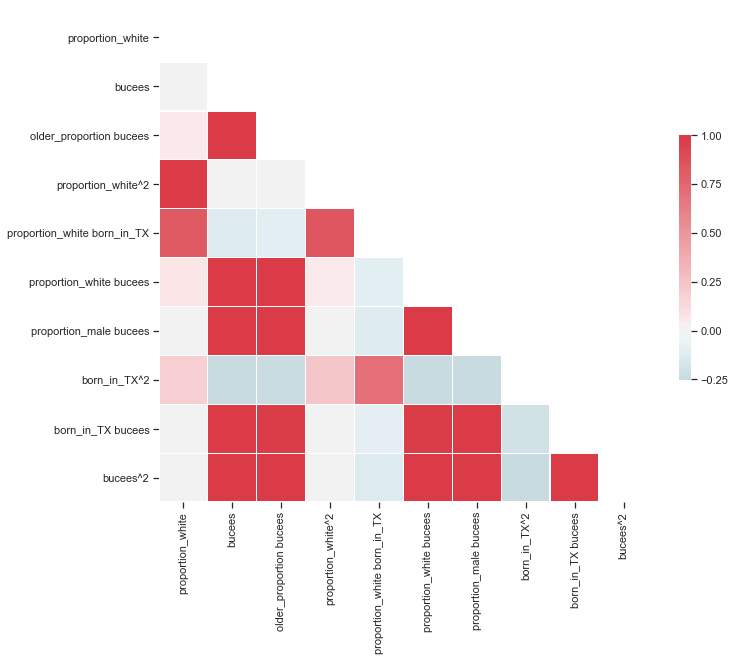

In [112]:
#review correlations in a heatmap to see if any are closely correlated; 

sns.set(style="ticks")

corr = features_selected_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [116]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

features_selected_train.drop(columns=to_drop, inplace=True)
to_drop

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


['older_proportion bucees',
 'proportion_white^2',
 'proportion_white bucees',
 'proportion_male bucees',
 'born_in_TX bucees',
 'bucees^2']

* These would be the features variables to drop as they contribute to excessive multicollinearity.
* We now start a **mutual info regression** test

In [117]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [118]:
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(features_selected_train, y_train_features)
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

,proportion_white,bucees,proportion_white born_in_TX,born_in_TX^2
0,0.389004,0.0,0.299521,0.592855
1,0.681317,0.0,0.446600,0.429674
2,0.783354,0.0,0.690208,0.776325
3,0.501001,0.0,0.397997,0.631078
4,0.782285,0.0,0.536150,0.469723


In [119]:
features_selected_train = information_selector(features_selected_train, y_train_features, mutual_info_regression, k='all')

In [120]:
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train_features)

features_selected_test = features_plus_test[features_selected_train.columns]
y_pred_features = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test_features, y_pred_features))
print(metrics.mean_squared_error(y_test_features, y_pred_features))
print(np.sqrt(metrics.mean_squared_error(y_test_features, y_pred_features)))

0.10821166421163743
0.017433338200862812
0.13203536723492995


This attempt returned a MSE of 0.0174, which is about 50% higher than our Attempt 2 MSE of 0.00909, concluding that Attempt 2 was better!